# Random Forest Homework

Если вы дошли до этой точки, поздравляю, вы уже на полпути к успешному решению домашнего задания!

Итак, начнем...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import random
import scipy.stats as sps
import math
from sklearn.datasets import load_wine
from sklearn.model_selection import StratifiedKFold,cross_validate,train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,mean_absolute_error,mean_squared_error,r2_score,make_scorer

### Задание №1:  Загрузите и обработайте данные

Для начала загрузим датасет:

In [2]:
X, y = load_wine(return_X_y=True, as_frame=True)

In [3]:
X.shape

(178, 13)

In [4]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


Собственно само задание:
1) Постройте гистограмму распределения данных по классам  
   Ответ: распределение классов практически одинаково, что говорит о том, что датасет сбалансированный
2) Постройте boxplot по фичам, для того чтобы увидеть распределение признаков  
   Ответ: как мы видим большой разброс значений только у признака proline(и возможно, magnesium), у остальных же признаков разброс совсем невелик, что не совсем хорошо, так как возможно, будет сложнее получить разнообразные выборки при повторных выборах с заменой. Это может привести к тому, что бутстрэп-выборки будут слишком похожи друг на друга, что снизит эффективность метода бутстрэпа.
3) Постройте heatmap корреляции признаков с помощью seaborn  
   Ответ: Больше всего коррелируют flavanoids и total_phenols, совершенно не коррелируют flavanoids и nonflavanoid_phenols, но высокая корреляция у многих пар признаков, что может говорить нам о том, что нет необходимости учиться на всех признаках, так как они коррелируют

В каждом пункте сделайте выводы относительно полученных графиков

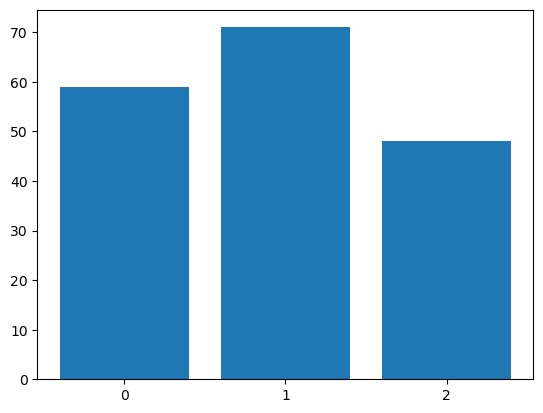

In [5]:
labels, counts = np.unique(y, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

<Axes: >

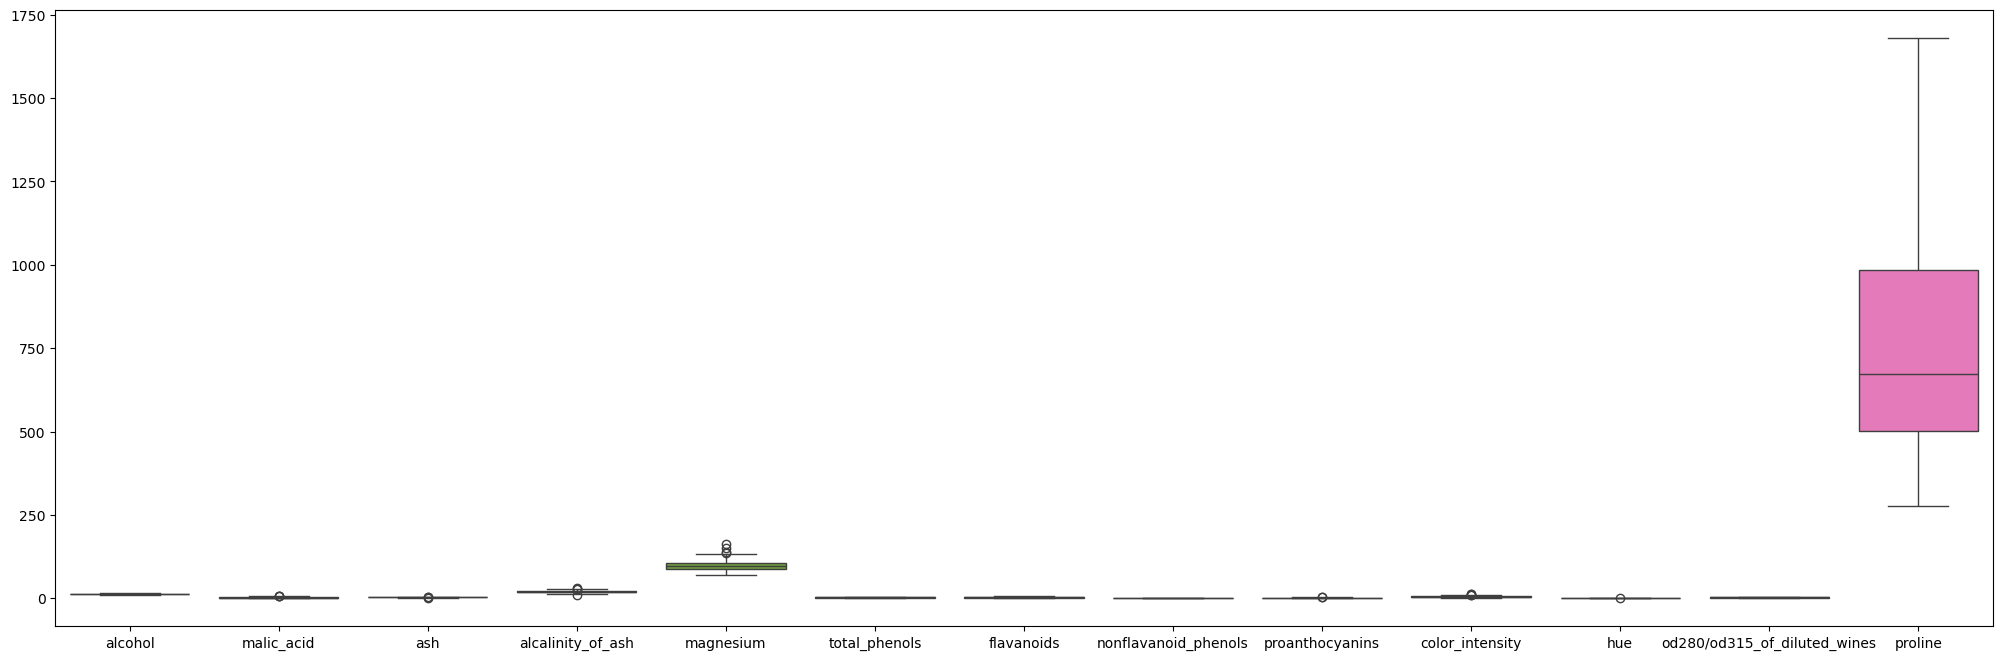

In [6]:
plt.figure(figsize=(25,8))
sns.boxplot(X)

<Axes: ylabel='proline'>

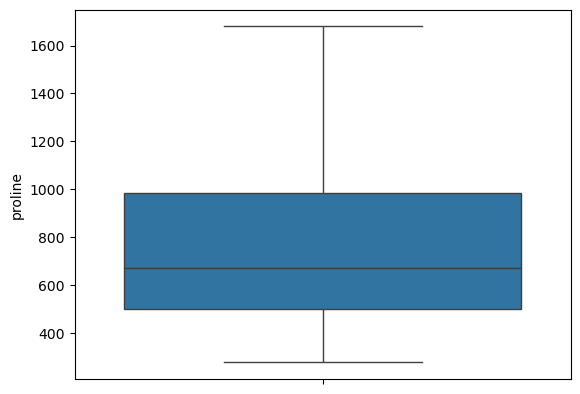

In [7]:
#split the data, to see all boxplots
sns.boxplot(X.proline)

<Axes: ylabel='magnesium'>

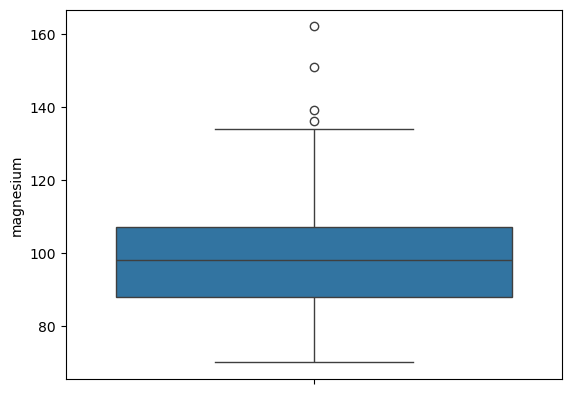

In [8]:
sns.boxplot(X.magnesium)

<Axes: >

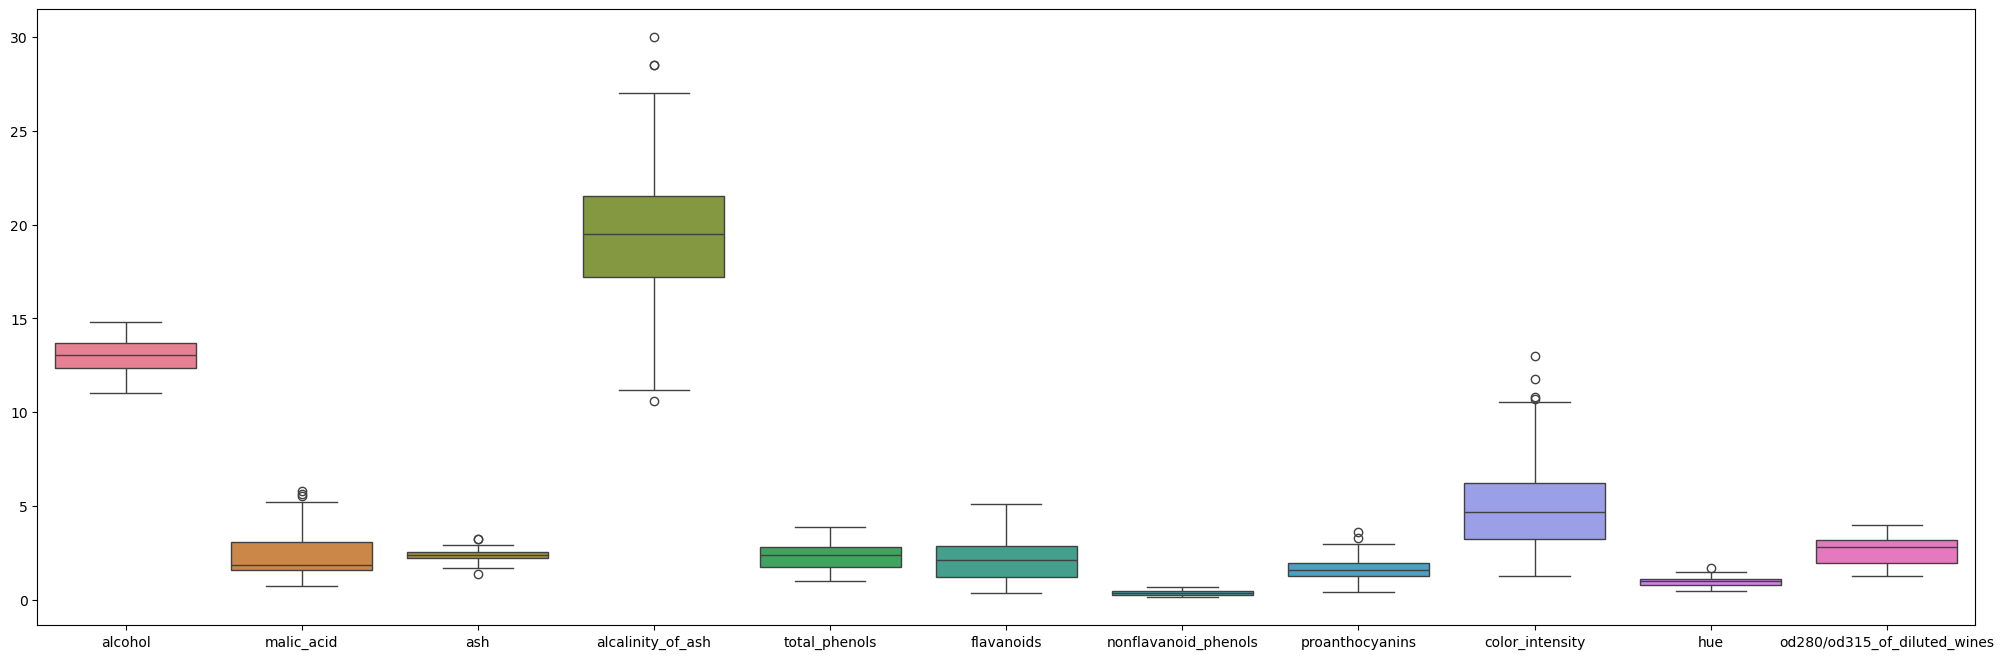

In [9]:
plt.figure(figsize=(25,8))
X_new = X.drop(columns = ['proline', 'magnesium'])
sns.boxplot(X_new)

<Axes: >

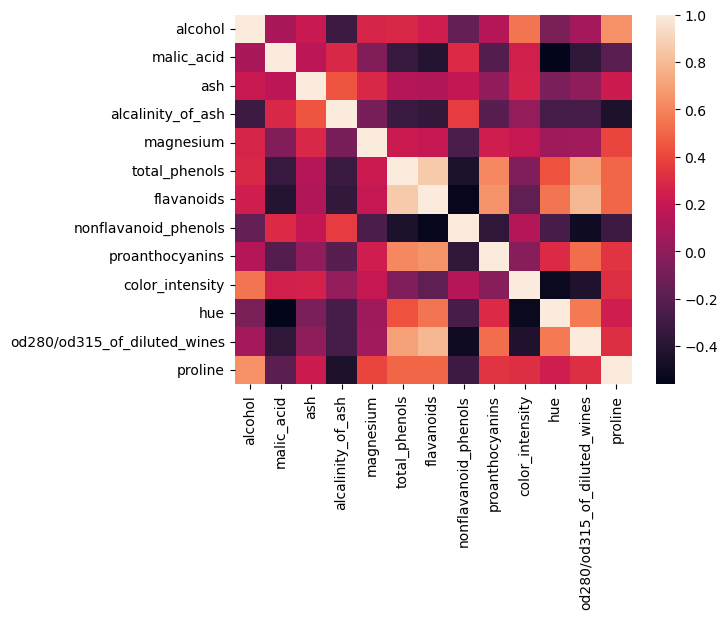

In [10]:
corr_matrix = X.corr()
sns.heatmap(corr_matrix)

## Bagging

По традиции начнем с невероятной истории:

Фрэнсис Гальтон в 1906 году посетил рынок, где проводилась некая лотерея для крестьян. 
Их собралось около 800 человек, и они пытались угадать вес быка, который стоял перед ними. Бык весил 1198 фунтов. Ни один крестьянин не угадал точный вес быка, но если посчитать среднее от их предсказаний, то получим 1197 фунтов.

![1198bull](./sources/bull.jpeg)

## Bootstrap

Метод бутстрэпа заключается в следующем. Пусть имеется выборка $\large X$ размера $\large N$. Равномерно возьмем из выборки $\large N$ объектов с возвращением. Это означает, что мы будем $\large N$ раз выбирать произвольный объект выборки (считаем, что каждый объект «достается» с одинаковой вероятностью $\large \frac{1}{N}$), причем каждый раз мы выбираем из всех исходных $\large N$ объектов. Можно представить себе мешок, из которого достают шарики: выбранный на каком-то шаге шарик возвращается обратно в мешок, и следующий выбор опять делается равновероятно из того же числа шариков. Отметим, что из-за возвращения среди них окажутся повторы. Обозначим новую выборку через $\large X_1$. Повторяя процедуру $\large M$ раз, сгенерируем $\large M$ подвыборок $\large X_1, \dots, X_M$. Теперь мы имеем достаточно большое число выборок и можем оценивать различные статистики исходного распределения.

![bootstrap](./sources/bootstrap.jpeg)

### Задание №2: Реализуйте функцию бутстрепа

In [11]:
def make_bootstraps(data, n_samples):
    """
    Generates bootstrap samples for given data
    
    Parameters
    ----------
    data : np.array of type float with shape (n_datapoints, n_features)
           Dataset
           
    n_samples : int
                Count of bootstrap samples
     
    Returns
    -------
    dict
        Dictionary with n_samples bootstrap samples
    """
    bootstrap = {}
    sample_size = data.shape[0]

    for sample in range(n_samples):
        bootstrap_sample_indices = np.random.choice(sample_size, size=sample_size, replace=True)
        bootstrap_sample_data = data[bootstrap_sample_indices]
        
        train_sample, test_sample = train_test_split(bootstrap_sample_data, test_size=0.37)  
        bootstrap["tree_" + str(sample)] = {'train': train_sample, 'test': test_sample}

    return bootstrap

После того, как функция реализована, проверьте, что бутстреп реализован правильно: 
1) Сгенерируйте выборку из стандартного нормального распределения размера 30
2) Сделайте 1000 бутстреп выборок с помощью функции make_bootstrap и найдите среднее значение в каждой из них
3) На основании полученных 1000 средних постройте гистограмму
4) Постройте на этом же графике функцию плотности стандартного нормального распределения

Тест пройден успешно, если гистограмма приближает столбиками функцию плотности

P. S. В статистике принято выбирать количество бинов на гистограмме как $ log_{2}(n) $, где n размер выборки

In [12]:
arr = np.random.normal(size=30)
bootstrap = make_bootstraps(arr, 1000)
values = list(bootstrap.values())
means = []
for i in range(1000):
    means.append(np.concatenate((list(values[i].values())[0], list(values[i].values())[1])).mean())

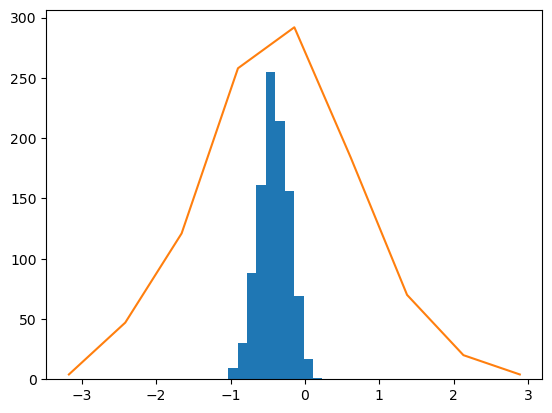

In [13]:
plt.hist(means, bins = round(math.log2(1000)))

y1 = np.random.normal(0, 1, 1000)
x1 = np.arange(1000)
count, bins = np.histogram(y1, bins = int(np.log2(1000)))
plt.plot(bins[:-1], count)

## Out-of-bag error

Поясним, зачем в примере выше нужна тестовая выборка

Забегая вперед, отметим, что при использовании случайных лесов нет необходимости в кросс-валидации или в отдельном тестовом наборе, чтобы получить несмещенную оценку ошибки набора тестов. Посмотрим, как получается "внутренняя" оценка модели во время ее обучения.

Каждое дерево строится с использованием разных образцов бутстрэпа из исходных данных. Примерно 37% примеров остаются вне выборки бутстрэпа и не используются при построении k-го дерева.

Это можно легко доказать: пусть в выборке $\large \ell$ объектов. На каждом шаге все объекты попадают в подвыборку с возвращением равновероятно, т.е отдельный объект — с вероятностью $\large\frac{1}{\ell}.$ Вероятность того, что объект НЕ попадет в подвыборку (т.е. его не взяли $\large \ell$ раз): $\large (1 - \frac{1}{\ell})^\ell$. При $\large \ell \rightarrow +\infty$ получаем один из "замечательных" пределов $\large \frac{1}{e}$. Тогда вероятность попадания конкретного объекта в подвыборку $\large \approx 1 - \frac{1}{e} \approx 63\%$.

Давайте рассмотрим, как это работает на практике:

![oobe](./sources/oobe.png)

На рисунке изображена оценка oob-ошибки. Верхний рисунок – это наша исходная выборка, ее мы делим на обучающую(слева) и тестовую(справа). На рисунке слева у нас есть сетка из квадратиков, которая идеально разбивает нашу выборку. Теперь нужно оценить долю верных ответов на нашей тестовой выборке. На рисунке видно, что наш классификатор ошибся в 4 наблюдениях, которые мы не использовали для обучения. Значит, доля верных ответов нашего классификатора: $\large \frac{11}{15}*100\% = 73.33\%$

Получается, что каждый базовый алгоритм обучается на ~63% исходных объектов. Значит, на оставшихся ~37% его можно сразу проверять. Out-of-Bag оценка — это усредненная оценка базовых алгоритмов на тех ~37% данных, на которых они не обучались.

## Случайный лес

Лео Брейман нашел применение бутстрэпу не только в статистике, но и в машинном обучении. Он вместе с Адель Катлер усовершенстовал алгоритм случайного леса, предложенный Хо, добавив к первоначальному варианту построение некоррелируемых деревьев на основе CART, в сочетании с методом случайных подпространств и бэггинга.

Решающие деревья являются хорошим семейством базовых классификаторов для бэггинга, поскольку они достаточно сложны и могут достигать нулевой ошибки на любой выборке. Метод случайных подпространств позволяет снизить коррелированность между деревьями и избежать переобучения. Базовые алгоритмы обучаются на различных подмножествах признакового описания, которые также выделяются случайным образом.
Ансамбль моделей, использующих метод случайного подпространства, можно построить, используя следующий алгоритм:

1) Пусть количество объектов для обучения равно $\large N$, а количество признаков $\large D$.
2) Выберите $\large L$ как число отдельных моделей в ансамбле.
3) Для каждой отдельной модели $\large l$ выберите $\large dl (dl < D) $ как число признаков для $\large l$. Обычно для всех моделей используется только одно значение $\large dl$.
4) Для каждой отдельной модели $\large l$ создайте обучающую выборку, выбрав $\large dl$ признаков из $\large D$, и обучите модель.
5) Теперь, чтобы применить модель ансамбля к новому объекту, объедините результаты отдельных $\large L$ моделей мажоритарным голосованием или путем комбинирования апостериорных вероятностей.

### Алгоритм

Алгоритм построения случайного леса, состоящего из $\large N$ деревьев, выглядит следующим образом:

- Для каждого $\large n = 1, \dots, N$:
     - Сгенерировать выборку $\large X_n$ с помощью бутстрэпа;
     - Построить решающее дерево $\large b_n$ по выборке $\large X_n$:
         - по заданному критерию мы выбираем лучший признак, делаем разбиение в дереве по нему и так до исчерпания выборки
         - дерево строится, пока в каждом листе не более $\large n_\text{min}$ объектов или пока не достигнем определенной высоты дерева
         - при каждом разбиении сначала выбирается $\large m$ случайных признаков из $\large n$ исходных, и оптимальное разделение выборки ищется только среди них.

Итоговый классификатор $\large a(x) = \frac{1}{N}\sum_{i = 1}^N b_i(x)$, простыми словами — для задачи кассификации мы выбираем решение голосованием по большинству, а в задаче регрессии — средним.

Рекомендуется в задачах классификации брать $\large m = \sqrt{n}$, а в задачах регрессии — $\large m = \frac{n}{3}$, где $\large n$ — число признаков. Также рекомендуется в задачах классификации строить каждое дерево до тех пор, пока в каждом листе не окажется по одному объекту, а в задачах регрессии — пока в каждом листе не окажется по пять объектов.

Таким образом, случайный лес — это бэггинг над решающими деревьями, при обучении которых для каждого разбиения признаки выбираются из некоторого случайного подмножества признаков.

### Задание №3: Допишите классы в модуле forest (workdir/forest/forest.py)

Обратите внимание, что папки в контейнере и на компьютере синхронизированы, а это значит, что вы можете открыть модуль в любом удобном IDE на компьютере и все изменения тут же произойдут в контейнере.

Задание:
1) Допишите недостающий код в workdir/forest/forest.py
2) Сравните accuracy/precision/recall с имплементацией из библиотеки sklearn  
   Ответ: как мы видим качество имплементации из sklearn немного выше нашей имплементации(примерно на 0,05), что говорит нам о том, что еще есть что улучшать в нашей имплементации

In [14]:
import AwesomeTester
from forest.forest import RandomForestClassifier

In [15]:
forest = RandomForestClassifier(balance_class_weights=True)
forest.fit(X.values, y.values, print_metrics=True)

Standard error in accuracy: 0.04
Standard error in precision: 0.03
Standard error in recall: 0.04


In [16]:
scoring_metrics = {'accuracy': make_scorer(accuracy_score), 
                   'precision': make_scorer(precision_score, average='weighted'),
                   'recall': make_scorer(recall_score, average='weighted')}
scores        = cross_validate(forest, X.values, y.values, cv=StratifiedKFold(10), scoring=scoring_metrics)

if (AwesomeTester.magic(np.mean(scores['test_accuracy']))):
    print("Congratulations!")
else:
    print("Oooooops... Something went wrong :(")

# CHECK ACCURACY, PRECISION AND RECALL

Congratulations!


In [17]:
print('Accuracy:', np.mean(scores['test_accuracy']))
print('Precision:', np.mean(scores['test_precision']))
print('Recall:', np.mean(scores['test_recall']))

Accuracy: 0.9388888888888889
Precision: 0.9496141975308643
Recall: 0.9388888888888889


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [19]:
mod = RandomForestClassifier()
mod.fit(X.values, y.values)

RandomForestClassifier()

In [20]:
scores_1 = cross_validate(mod, X.values, y.values, cv=StratifiedKFold(10), scoring=scoring_metrics)

In [21]:
print('Accuracy:', np.mean(scores_1['test_accuracy']))
print('Precision:', np.mean(scores_1['test_precision']))
print('Recall:', np.mean(scores_1['test_recall']))

Accuracy: 0.9718954248366012
Precision: 0.9764118425147836
Recall: 0.9718954248366012
